# Visão Computacional Entrega 2 - Fechadura Automática
Alunos:
- Gabriel Alves Kuabara - 11275043
- Gabriel Freitas Ximenes de Vasconcelos - 11819084
- Gabriel Victor Cardoso Fernandes - 11878296

In [44]:
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Preprocessing the images used for training

In [11]:
def detect_face_and_save():
    folder_name = 'photos'

    # dimension of images
    image_width = 224
    image_height = 224

    # for detecting faces
    facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # set the directory containing the images
    images_dir = os.path.join(".", folder_name)

    current_id = 0
    label_ids = {}

    # iterates through all the files in each subdirectories
    for root, _, files in os.walk(images_dir):
        for file in files:
            if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
                # path of the image
                path = os.path.join(root, file)

                # get the label name (name of the person)
                label = os.path.basename(root).replace(" ", ".").lower()

                # add the label (key) and its number (value)
                if not label in label_ids:
                    label_ids[label] = current_id
                    current_id += 1

                # load the image
                imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
                image_array = np.array(imgtest, "uint8")
                # get the faces detected in the image
                faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)
                face_qty = len(faces)
                if face_qty == 0:
                    print(f"Face detector found 0 faces in file '{file}'")
                    os.remove(path)

                # save the detected face(s) and associate
                # them with the label
                for (x_, y_, w, h) in faces[:1]:

                    # resize the detected face to 224x224
                    size = (image_width, image_height)

                    # detected face region
                    roi = image_array[y_: y_ + h, x_: x_ + w]

                    # resize the detected head to target size
                    resized_image = cv2.resize(roi, size)
                    image_array = np.array(resized_image, "uint8")

                    # remove the original image
                    os.remove(path)

                    # replace the image with only the face
                    im = Image.fromarray(image_array)
                    im.save(path)

In [12]:
detect_face_and_save()

.\photos\Unknown
File '1 (100).png' has 0 faces bro
File '1 (1025).jpg' has 0 faces bro
File '1 (1045).jpg' has 0 faces bro
File '1 (1056).jpg' has 0 faces bro
File '1 (106).jpg' has 0 faces bro
File '1 (1072).jpg' has 0 faces bro
File '1 (1081).jpg' has 0 faces bro
File '1 (109).jpg' has 0 faces bro
File '1 (1094).jpg' has 0 faces bro
File '1 (1103).jpg' has 0 faces bro
File '1 (1112).jpg' has 0 faces bro
File '1 (1117).jpg' has 0 faces bro
File '1 (1118).jpg' has 0 faces bro
File '1 (1122).jpg' has 0 faces bro
File '1 (113).jpg' has 0 faces bro
File '1 (1148).jpg' has 0 faces bro
File '1 (116).jpg' has 0 faces bro
File '1 (1168).jpg' has 0 faces bro
File '1 (1184).jpg' has 0 faces bro
File '1 (1192).jpg' has 0 faces bro
File '1 (1193).jpg' has 0 faces bro
File '1 (1225).jpg' has 0 faces bro
File '1 (1229).jpg' has 0 faces bro
File '1 (1231).jpg' has 0 faces bro
File '1 (1242).jpg' has 0 faces bro
File '1 (1245).jpg' has 0 faces bro
File '1 (125).jpg' has 0 faces bro
File '1 (125).png

# Build the neural network

In [14]:
from keras_vggface.vggface import VGGFace

# Augmenting the Training Images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'photos',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

# Number of classes we have
n_classes = len(train_generator.class_indices.values())

# Building the model
def generate_model():
    # Use 19 layers from original VGG-Face
    base_model = VGGFace(
        include_top=False,
        model='vgg16',
        input_shape=(224, 224, 3)
    )

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)

    # final layer with softmax activation
    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs = base_model.input, outputs = predictions)

    # Freeze training for the first 19 layers (keep VGG's feature extraction)
    for layer in model.layers[:19]:
        layer.trainable = False

    # Train the rest of the layers - 19 onwards
    for layer in model.layers[19:]:
        layer.trainable = True

    return model

model = generate_model()

Found 6471 images belonging to 4 classes.


In [15]:
# Saving the training labels
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {value:key for key, value in class_dictionary.items()}
print(class_dictionary)

# save the class dictionary with pickle format
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

{0: 'Dorime', 1: 'Kibon', 2: 'Ku', 3: 'Unknown'}


# K-fold cross validation

In [17]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load dataset
def load_dataset(folder):
    images = image_dataset_from_directory(
        directory=folder,
        label_mode='categorical',
        image_size=(224, 224),
        color_mode='rgb',
        shuffle=True
    )
    return images

In [18]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

# General definitions
loss_fn = 'categorical_crossentropy'
optimizer = 'Adam'
metrics = ['accuracy']

batch_size = 1
verbose = 1
epochs = 20

num_folds = 5

# Merge inputs and targets
inputs = load_dataset('./photos')

train_images = np.concatenate(list(inputs.map(lambda x, y:x)))
train_labels = np.concatenate(list(inputs.map(lambda x, y:y)))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
early_stopping = EarlyStopping()

# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []
for fold_no, (train, test) in enumerate(kfold.split(train_images, train_labels)):
    # Define the model architecture then compile
    model = generate_model()
    model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(train_generator, batch_size=batch_size, verbose=verbose, epochs=epochs, callbacks=[early_stopping], validation_data=(train_images[test], train_labels[test]))

    # Generate generalization metrics
    scores = model.evaluate(train_images[test], train_labels[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# creates a HDF5 file
model.save(
    'k_fold_trained' +
    '_face_cnn_model.h5')

Found 6471 files belonging to 4 classes.
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/20
203/203 [==============================] - 28s 135ms/step - loss: 0.0648 - accuracy: 0.9853 - val_loss: 50.7064 - val_accuracy: 0.9691
Epoch 2/20
203/203 [==============================] - 26s 129ms/step - loss: 0.0155 - accuracy: 0.9947 - val_loss: 88.2797 - val_accuracy: 0.9676
Score for fold 0: loss of 88.27967071533203; accuracy of 96.75675630569458%
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
203/203 [==============================] - 30s 146ms/step - loss: 0.0837 - accuracy: 0.9818 - val_loss: 41.7178 - val_accuracy: 0.9753
Epoch 2/20
203/203 [==============================] - 26s 129ms/step - loss: 0.0137 - accuracy: 0.9952 - val_loss: 78.5031 - val_accuracy: 0.9768
Score for fold 1: loss of 78.50308227539062; accuracy of 97.68160581588745%
-----------------------------

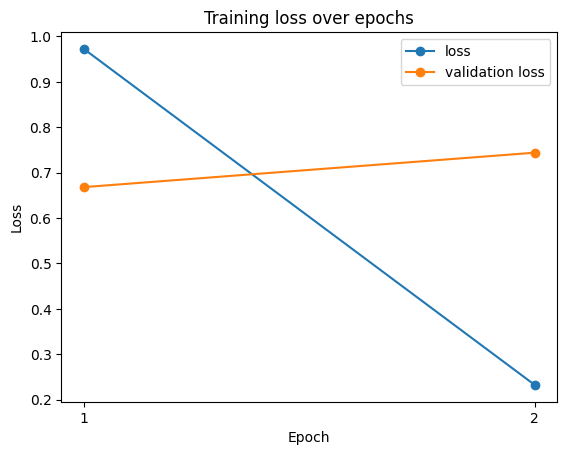

In [54]:
# plotting the loss vs. epochs graph on the training and validation sets

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

y = np.array(history.history['loss'])
y_norm = np.linalg.norm(y)
if y_norm != 0: y = y/y_norm

val_y = np.array(history.history['val_loss'])
y_norm = np.linalg.norm(val_y)
if y_norm != 0: val_y = val_y/y_norm

x = np.array([i for i in range(len(y))]) + 1

import matplotlib.pyplot as plt

plt.plot(x, y, marker='o', label="loss")
plt.plot(x, val_y, marker='o', label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, 3))
plt.title("Training loss over epochs")
plt.legend()
plt.show()

# Testing the Trained Model

In [55]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
import keras.utils as image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as f:
    class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)

['Dorime', 'Kibon', 'Ku', 'Unknown']


Now on file photo_2023-06-20_23-58-34.jpg of subdir facetest\Dorime
1/1 [==============================] - 0s 20ms/step
[[1. 0. 0. 0.]]
Now on file photo_2023-06-20_23-58-38.jpg of subdir facetest\Dorime
1/1 [==============================] - 0s 17ms/step
[[1. 0. 0. 0.]]
Now on file photo_2023-06-23_20-51-58.jpg of subdir facetest\Dorime
1/1 [==============================] - 0s 15ms/step
[[1. 0. 0. 0.]]
Now on file photo_2023-06-23_20-54-17.jpg of subdir facetest\Dorime
1/1 [==============================] - 0s 17ms/step
[[1. 0. 0. 0.]]
Now on file photo_2023-06-23_21-40-33.jpg of subdir facetest\Dorime
1/1 [==============================] - 0s 16ms/step
[[1. 0. 0. 0.]]
Now on file 20230623_174237.jpg of subdir facetest\Kibon
1/1 [==============================] - 0s 17ms/step
[[0.0000000e+00 9.9999952e-01 4.5743752e-07 0.0000000e+00]]
Now on file 20230623_174243.jpg of subdir facetest\Kibon
1/1 [==============================] - 0s 17ms/step
[[0.000000e+00 1.000000e+00 9.154334e-12 0

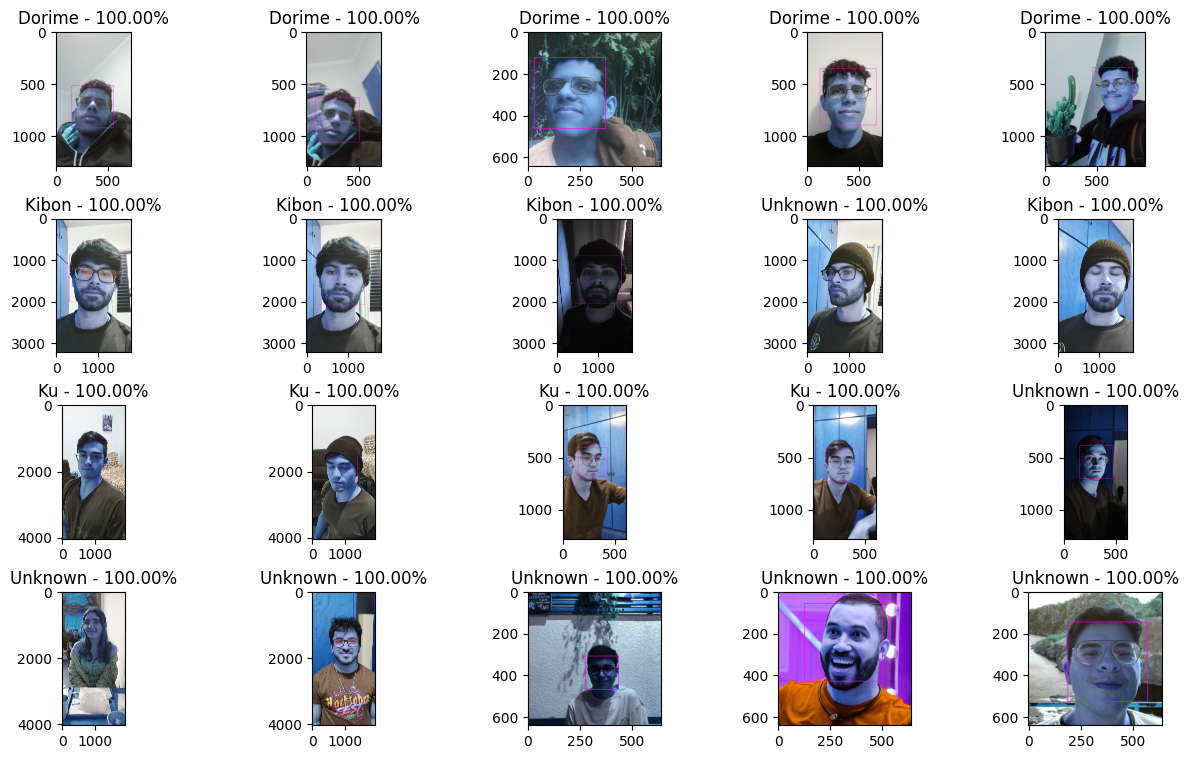

In [43]:
# Predicting the faces
facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

files = [os.path.join(dp, f) for dp, dn, filenames in os.walk("./facetest") for f in filenames]
subdirectories = [x[0] for x in os.walk('facetest')][1:]

fig = plt.figure(figsize=(16, 9))

none_count = 0
for i, subdirectory in enumerate(subdirectories):
    for j, file in enumerate(os.listdir(subdirectory)):
        test_image_filename = os.path.join(subdirectory, file)
        print(f"Now on file {file} of subdir {subdirectory}")
        # load the image
        imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
        if imgtest is None:
            none_count += 1
            print(f"{test_image_filename} was None ({none_count} nones)")

        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.1, minNeighbors=5)

        for (x_, y_, w, h) in faces[:1]:
            # draw the face detected
            face_detect = cv2.rectangle(imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)

            # resize the detected face to 224x224
            size = (image_width, image_height)
            roi = image_array[y_: y_ + h, x_: x_ + w]
            resized_image = cv2.resize(roi, size)

            # prepare the image for prediction
            x = image.img_to_array(resized_image)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x, version=1)

            # making prediction
            predicted_prob = model.predict(x)
            print(predicted_prob)
            
            ax = fig.add_subplot(4, 5, (i*5)+(j+1))
            ax.imshow(face_detect)
            pred_class = predicted_prob[0].argmax()
            pred_probability = predicted_prob[0][pred_class]*100
            ax.set_title("{0} - {1:.2f}%".format(class_list[pred_class], pred_probability))

plt.subplots_adjust(wspace=0.05, hspace=0.40)
plt.show()